In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
matplotlib.rc("font", size=16)
plt.style.use("tableau-colorblind10")

# NE 536: Homework 3
## Micah Gale
17 Oct 2025

## Problem 3.1 Helium-4 production
Using ENDF/B-VII.1 data 

In [2]:
def parse_xs(path):
    return pd.read_csv(path,sep=r"\s+", names=["E", "sig"], skiprows=1, usecols=range(2))
def plot_xs(xs_data, label, xlim=(1,20e6)):
    plt.loglog(xs_data["E"], xs_data["sig"], label=label)
    plt.xlabel("Neutron Energy [eV]")
    plt.ylabel("cross-section [b]")
    plt.xlim(xlim)
    plt.legend()

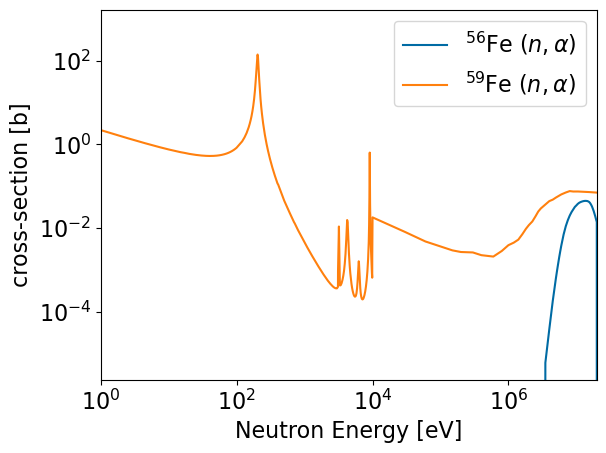

In [3]:
fe56 = parse_xs("fe-56-na.csv")
plot_xs(fe56, r"$^{56}$Fe $(n,\alpha)$")
plot_xs(parse_xs("Ni-59-na.csv"), r"$^{59}$Fe $(n,\alpha)$")

### Q3.1.2

I couldn't help myself, and had to also plot the $(n,\alpha)$ reaction for Ni-59 as well. 
Ni-59 is a rather unique nuclide because it has a non-threshold $(n,\alpha)$ reaction,
and this has intrigued Greenwood.
In pure nickel in a purely thermal neutron spectrum over 10% of the radiation damage (dpa) comes from Ni-59 [doi:10.1016/0022-3115(83)90302-1](https://doi.org/10.1016/0022-3115(83)90302-1).

Anyways, $(n,\alpha)$ have a very large problem: they are pumping helium into your crystals.
Now this helium can migrate to grain boundaries and diffuse out, but in general it does not leave.
Eventually this will lead to helium-stabalized void swelling, where the helium will fill the voids formed through radiation damage.
This will provide enough internal pressure eventually so these voids can't collapse naturally.
Once this saturation point is reached there is usually a "hockey-stick" change in swelling and materials will begin swelling much faster.

Ni-59 has additional insult to injury because the only way for this reaction to be non-threshold is for it to be exothermic. 
This means that in every reaction the resulting nucleus (Fe-56) will recoil with about 56 keV of energy and can do signicant radiation damage.

In fusion power plants you have much higher fast flux that will activate this threshold reaction in iron, so a fusion power plant (at least near the first wall) will have have much higher helium generation than a fission power plant will in its steel.

## Problem 3.2 Lithium Blanket
Yay ENDF/B-VII.1

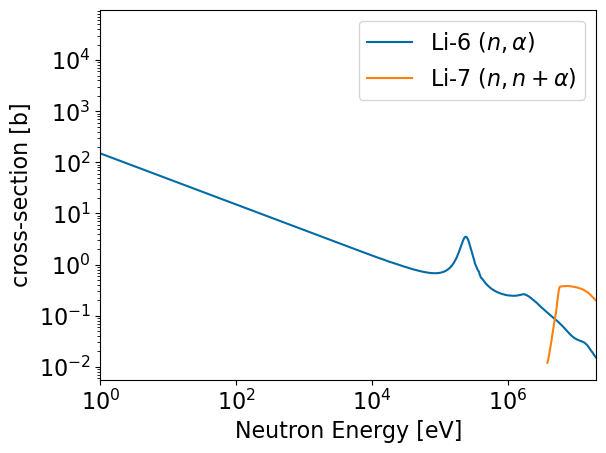

In [4]:
for nuclide, file_rx, label_rx in [("Li-6","na", r"n, \alpha"),  ("Li-7", "nn+a", r"n, n + \alpha")]:
    plot_xs(parse_xs(f"{nuclide}{file_rx}.csv"), f"{nuclide} $({label_rx})$")

### Q3.2.2 Calculate Q-Value

The energy release of a reaction, $Q$ is the mass energy difference between the reactants and the products:

$$ Q = \sum^{react} E_{m} - \sum^{prod} E_{m}$$

All mass data taken from [Live chart](https://www-nds.iaea.org/relnsd/vcharthtml/VChartHTML.html)

In [5]:
#all masses in mirco-AMU
m_n =   1008664.9159
m_tritium = 3016049.28132
m_alpha = 4002603.25413
m_li6 = 6015122.8874
m_li7 = 7016003.434

MEV_PER_AMU = 931.494103 # [MeV/amu]
EV_PER_mAMU = MEV_PER_AMU

In [6]:
q_li6 = m_li6 + m_n - m_alpha - m_tritium
q_li6 *= EV_PER_mAMU
q_li7 = m_li7+ m_n - m_n - m_alpha - m_tritium
q_li7 *= EV_PER_mAMU

In [7]:
print(f"Q for tritium production from Li-6: {q_li6/1e6:.2f} MeV")
print(f"Q for tritium production from Li-7: {q_li7/1e6:.2f} MeV")

Q for tritium production from Li-6: 4.78 MeV
Q for tritium production from Li-7: -2.47 MeV


This makes sense since Li-6 is non-threshold and is therefore exothermic.
On the other hand Li-7 is a threshold reaction and endothermic,
which makes sense for a negative Q-value.
In fact the Q-value is very close to the threshold for this reaction.

## Q3.3 - Neutron Test Sources


* FLARE  neutron flux: $4.1\times 10^9 \frac{n}{cm^2-s}$ [1]
* IFMIF-DONE: $1\times 10^{18} \frac{n}{m^2-s}$ = $1\times10^{14} \frac{n}{cm^2-s}$ [2]

 
  
[1] Shine Fusion, “Fusion Linear Accelerator for Radiation Effects.” Accessed: Oct. 16, 2025. [Online]. Available: https://cdn.prod.website-files.com/63bc8628e53c0011f41ce702/67d084b6895ca88d4d9952df_ST%20FLARE%20Brochure%2002.26.2025.pdf

[2] J. Knaster et al., “IFMIF, the European–Japanese efforts under the Broader Approach agreement towards a Li(d,xn) neutron source: Current status and future options,” Nuclear Materials and Energy, vol. 9, pp. 46–54, Dec. 2016, doi: 10.1016/j.nme.2016.04.012.

### Neutron Wall Loading

Really Neutron wall loading is a neutron flux if you think about, just reported in ~lazy~ convenient for some people units.

To convert between the two the energy per fusion is needed. For $D-T$ fusion this is: 17.6 MeV.


In [8]:
FLARE_FLUX = 4.1e9 #n/cm2-s
IFMIF_FLUX = 1e14 #n/cm2-s

Q_DT = 17.6e6 # eV
J_PER_EV = 1.602e-19 #J/eV

wall_load = {}

for flux, name in [(FLARE_FLUX, "FLARE"), (IFMIF_FLUX, "IFMIF")]:
    flux_m2 = flux * 1e4 #[n/m2-s]
    ev_loading = flux_m2 * Q_DT #[eV/m2-s]
    wall_loading = ev_loading * J_PER_EV #[W/m2]
    wall_load[name] = wall_loading / 1e6
    print(f"{name} wall loading: {wall_loading/1e6:.2e} MW/m^2")

FLARE wall loading: 1.16e-04 MW/m^2
IFMIF wall loading: 2.82e+00 MW/m^2


### Q 3.3.2 Time to 50 DPA

First we need a realistic damage rate data. I found a convenient Paul Wilson Paper on FNSF that helped with this [3]. I used the first wall (outboard) data:

* neutron wall loading: 1.75 MW/m^2
* material: tungsten
* dpa rate: 13.7 dpa/FPY

Using this we can then do units bashing to get to a time to 50 dpa.


[3] A. Davis, M. Harb, L. El-Guebaly, P. Wilson, and E. Marriott, “Neutronics aspects of the FESS-FNSF,” Fusion Engineering and Design, vol. 135, pp. 271–278, Oct. 2018, doi: 10.1016/j.fusengdes.2017.06.008.


In [9]:
fnsf_wall_load = 1.75 # MW/m^2
fnsf_dpa_rate = 13.7 # dpa / year
DPA_TARGET = 50 # dpa

dpa_rate_per_wall = fnsf_dpa_rate / fnsf_wall_load #dpa-m^2/MW-year

In [10]:
for name, wall_loading in wall_load.items():
    dpa_rate = dpa_rate_per_wall * wall_loading
    time_to_limit = DPA_TARGET / dpa_rate
    print(f"{name} will take {time_to_limit:3,.1f} years to get to 50 dpa in Tungsten.")

FLARE will take 55,249.5 years to get to 50 dpa in Tungsten.
IFMIF will take 2.3 years to get to 50 dpa in Tungsten.
